In [2]:
import numpy as np
from standard_plots import *

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

import theano

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 720 (CNMeM is disabled, cuDNN not available)


# LSTMs

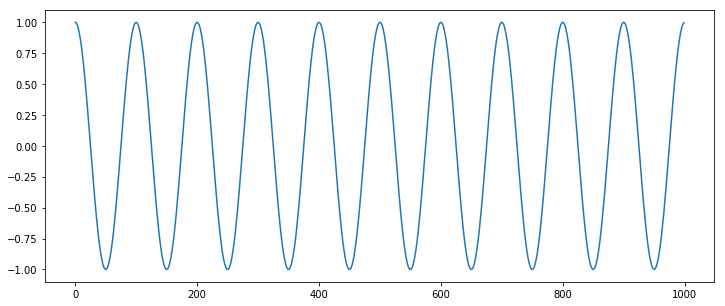

In [3]:
dataset = np.cos(np.arange(1000)*(20*np.pi/1000))[:,None]
plt_plot(y = dataset)

In [4]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

## Window of 20 time steps

In [5]:
look_back = 20
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [6]:
train.shape

(670, 1)

In [7]:
trainX.shape

(650, 20, 1)

In [8]:
trainY.shape

(650,)

In [9]:
%%time
theano.config.compute_test_value = "ignore"
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(32,input_dim=1))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=batch_size, verbose=2)

-c:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
-c:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, input_shape=(None, 1))`
/home/cesar/graphsenv/local/lib/python2.7/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/100
6s - loss: 0.0240
Epoch 2/100
6s - loss: 0.0072
Epoch 3/100
6s - loss: 0.0051
Epoch 4/100
6s - loss: 0.0044
Epoch 5/100
6s - loss: 0.0047
Epoch 6/100
7s - loss: 0.0038
Epoch 7/100
6s - loss: 0.0031
Epoch 8/100
7s - loss: 0.0036
Epoch 9/100
6s - loss: 0.0033
Epoch 10/100
6s - loss: 0.0026
Epoch 11/100
6s - loss: 0.0029
Epoch 12/100
6s - loss: 0.0025
Epoch 13/100
7s - loss: 0.0027
Epoch 14/100
6s - loss: 0.0023
Epoch 15/100
6s - loss: 0.0025
Epoch 16/100
6s - loss: 0.0022
Epoch 17/100
7s - loss: 0.0026
Epoch 18/100
7s - loss: 0.0023
Epoch 19/100
6s - loss: 0.0021
Epoch 20/100
6s - loss: 0.0023
Epoch 21/100
6s - loss: 0.0023
Epoch 22/100
7s - loss: 0.0026
Epoch 23/100
6s - loss: 0.0025
Epoch 24/100
6s - loss: 0.0023
Epoch 25/100
6s - loss: 0.0022
Epoch 26/100
6s - loss: 0.0021
Epoch 27/100
6s - loss: 0.0021
Epoch 28/100
6s - loss: 0.0024
Epoch 29/100
6s - loss: 0.0023
Epoch 30/100
6s - loss: 0.0025
Epoch 31/100
6s - loss: 0.0020
Epoch 32/100
6s - loss: 0.0021
Epoch 33/100
6s -

In [20]:
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX[:252], testY[:252], batch_size=batch_size, verbose=0)
print('Test Score: ', testScore)

('Train Score: ', 0.00031630845192624361)
('Test Score: ', 0.00028043942819990327)


In [21]:
look_ahead = 250
trainPredict = [np.vstack([trainX[-1][1:], trainY[-1]])]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([trainPredict[-1]]), batch_size=batch_size)
    predictions[i] = prediction
    trainPredict.append(np.vstack([trainPredict[-1][1:],prediction]))

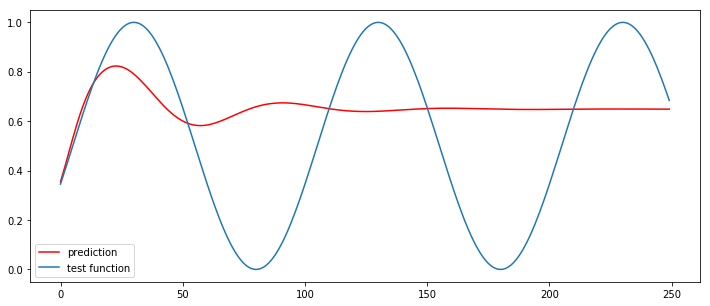

In [22]:
plt.figure(figsize=(12,5))
# plt.plot(np.arange(len(trainX)),np.squeeze(trainX))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(trainPredict)[:,None][1:]))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(testY)[:,None][:200]),'r')
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead)],label="test function")
plt.legend()
plt.show()

## Stateful LSTMs

In [23]:
look_back = 20
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [24]:
%%time
theano.config.compute_test_value = "ignore"
# create and fit the LSTM network
batch_size = 1
model = Sequential()
# model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(200):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()

CPU times: user 19min 46s, sys: 47.9 s, total: 20min 34s
Wall time: 20min 34s


In [25]:
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX[:252], testY[:252], batch_size=batch_size, verbose=0)
print('Test Score: ', testScore)

('Train Score: ', 0.00019369233611541859)
('Test Score: ', 0.00017577125286441023)


In [26]:
look_ahead = 250
trainPredict = [np.vstack([trainX[-1][1:], trainY[-1]])]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([trainPredict[-1]]), batch_size=batch_size)
    predictions[i] = prediction
    trainPredict.append(np.vstack([trainPredict[-1][1:],prediction]))

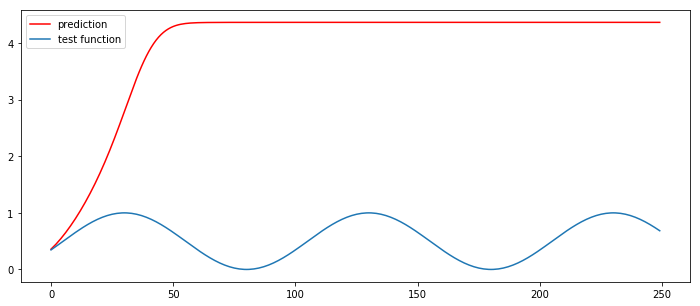

In [27]:
plt.figure(figsize=(12,5))
# plt.plot(np.arange(len(trainX)),np.squeeze(trainX))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(trainPredict)[:,None][1:]))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(testY)[:,None][:200]),'r')
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead)],label="test function")
plt.legend()
plt.show()

## Stateful LSTMs with wider window

In [28]:
look_back = 40
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [29]:
%%time
theano.config.compute_test_value = "ignore"
# create and fit the LSTM network
batch_size = 1
model = Sequential()
# model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
# model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(200):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()

CPU times: user 32min 40s, sys: 1min 36s, total: 34min 16s
Wall time: 34min 19s


In [30]:
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX[:252], testY[:252], batch_size=batch_size, verbose=0)
print('Test Score: ', testScore)

('Train Score: ', 0.00023877666582985718)
('Test Score: ', 0.00024658752446617865)


In [31]:
look_ahead = 250
trainPredict = [np.vstack([trainX[-1][1:], trainY[-1]])]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([trainPredict[-1]]), batch_size=batch_size)
    predictions[i] = prediction
    trainPredict.append(np.vstack([trainPredict[-1][1:],prediction]))

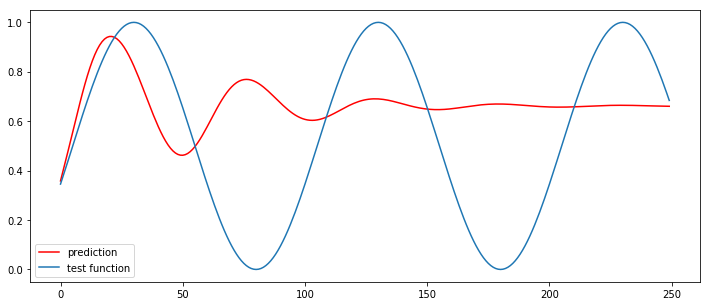

In [32]:
plt.figure(figsize=(12,5))
# plt.plot(np.arange(len(trainX)),np.squeeze(trainX))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(trainPredict)[:,None][1:]))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(testY)[:,None][:200]),'r')
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead)],label="test function")
plt.legend()
plt.show()

## Stateful LSTMs, Stacked

In [33]:
%%time
theano.config.compute_test_value = "ignore"
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(200):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()

CPU times: user 59min 47s, sys: 4min 8s, total: 1h 3min 56s
Wall time: 1h 4min 4s


In [34]:
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX[:252], testY[:252], batch_size=batch_size, verbose=0)
print('Test Score: ', testScore)

('Train Score: ', 0.00072789388967416742)
('Test Score: ', 0.00081207249679157842)


In [35]:
look_ahead = 250
trainPredict = [np.vstack([trainX[-1][1:], trainY[-1]])]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([trainPredict[-1]]), batch_size=batch_size)
    predictions[i] = prediction
    trainPredict.append(np.vstack([trainPredict[-1][1:],prediction]))

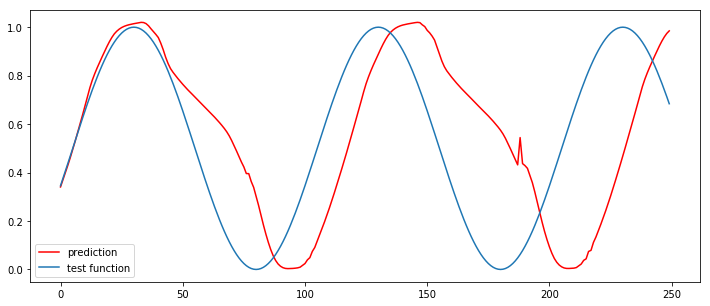

In [36]:
plt.figure(figsize=(12,5))
# plt.plot(np.arange(len(trainX)),np.squeeze(trainX))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(trainPredict)[:,None][1:]))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(testY)[:,None][:200]),'r')
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead)],label="test function")
plt.legend()
plt.show()

## Stateful LSTM stacked DEEPER!

In [37]:
%%time
theano.config.compute_test_value = "ignore"
# create and fit the LSTM network
batch_size = 1
model = Sequential()
for i in range(2):
    model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
    model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(200):
    model.fit(trainX, trainY, nb_epoch=1, batch_size=batch_size, verbose=0, shuffle=False)
    model.reset_states()

CPU times: user 1h 31min 31s, sys: 7min 15s, total: 1h 38min 47s
Wall time: 1h 39min 4s


In [33]:
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX[:252], testY[:252], batch_size=batch_size, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.00396572096143
Test Score:  0.00406088973036


In [34]:
look_ahead = 250
trainPredict = [np.vstack([trainX[-1][1:], trainY[-1]])]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([trainPredict[-1]]), batch_size=batch_size)
    predictions[i] = prediction
    trainPredict.append(np.vstack([trainPredict[-1][1:],prediction]))

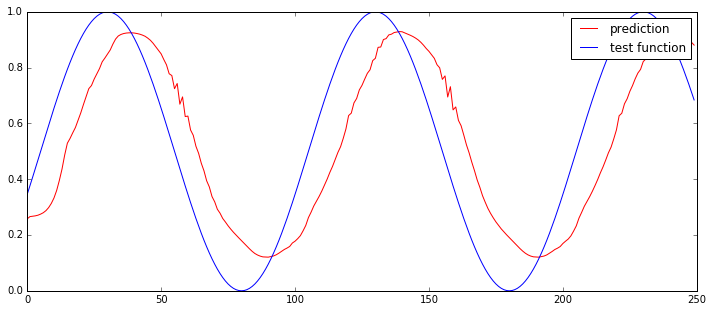

In [35]:
plt.figure(figsize=(12,5))
# plt.plot(np.arange(len(trainX)),np.squeeze(trainX))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(trainPredict)[:,None][1:]))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(testY)[:,None][:200]),'r')
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead)],label="test function")
plt.legend()
plt.show()

## Normal Deep Learning in Keras

In [50]:
%%time
trainX = np.squeeze(trainX)
testX = np.squeeze(testX)
theano.config.compute_test_value = "ignore"
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(Dense(output_dim=32,input_dim=40,activation="relu"))
model.add(Dropout(0.3))
for i in range(2):
    model.add(Dense(output_dim=32,activation="relu"))
    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adagrad')
model.fit(trainX, trainY, nb_epoch=100, batch_size=32, verbose=0)

CPU times: user 2.07 s, sys: 3.55 ms, total: 2.07 s
Wall time: 2.07 s


In [51]:
trainScore = model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
print('Train Score: ', trainScore)
testScore = model.evaluate(testX[:252], testY[:252], batch_size=batch_size, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.00816234733813
Test Score:  0.00758828630811


In [92]:
look_ahead = 250
xval = np.hstack([trainX[-1][1:], trainY[-1]])[None,:]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(xval, batch_size=32)
    predictions[i] = prediction
    xval = np.hstack([xval[:,1:],prediction])

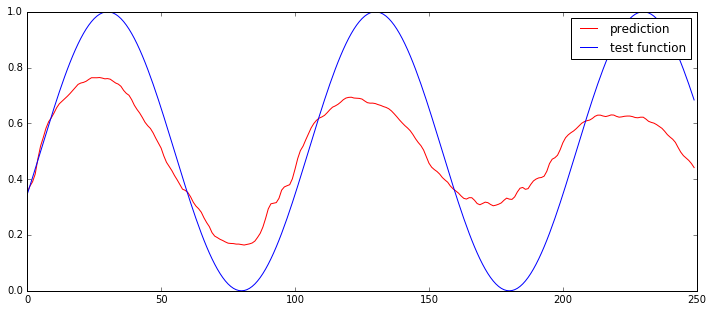

In [93]:
plt.figure(figsize=(12,5))
# plt.plot(np.arange(len(trainX)),np.squeeze(trainX))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(trainPredict)[:,None][1:]))
# plt.plot(np.arange(200),scaler.inverse_transform(np.squeeze(testY)[:,None][:200]),'r')
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead)],label="test function")
plt.legend()
plt.show()